In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, MaxPooling1D, Flatten, Dense, ReLU, LeakyReLU, Dropout, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, PReLU, ELU
from tensorflow.keras.regularizers import l2, l1_l2, l1
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import csv
import os
import glob
import pandas as pd

In [ ]:
plt.style.use('/content/fig.mplstyle')

In [ ]:
!git clone https://gitlab.com/siddinc/cs598-eeg-data.git

Cloning into 'cs598-eeg-data'...
remote: Enumerating objects: 324, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 324 (delta 0), reused 0 (delta 0), pack-reused 269
Receiving objects: 100% (324/324), 44.11 MiB | 9.04 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
def min_max_scaling(vector):
  normalized_vector = (vector - vector.min()) / (vector.max() - vector.min())
  return normalized_vector

def build_dataset(dst_path):
  dataset = {}
  data = glob.glob(dst_path)

  batch = np.zeros((50, 1903, 4), dtype=np.float64)
  gt_labels = []
  
  for i, file_path in enumerate(data):
    gt_labels.append(1 if file_path.split("/")[4] == "turn_on" else 0)
    df = pd.read_csv(file_path)
    
    ts_tp9 = df["TP9"].to_numpy()
    ts_tp10 = df["TP10"].to_numpy()
    ts_af7 = df["AF7"].to_numpy()
    ts_af8 = df["AF8"].to_numpy()
  
    batch[i,:,0] = min_max_scaling(ts_tp9[996:2899])
    batch[i,:,1] = min_max_scaling(ts_tp10[996:2899])
    batch[i,:,2] = min_max_scaling(ts_af7[996:2899])
    batch[i,:,3] = min_max_scaling(ts_af8[996:2899])

  dataset['x'] = batch
  dataset['y'] = np.array(gt_labels)
  return dataset

In [ ]:
dataset = build_dataset("/content/cs598-eeg-data/data_v3/*/*")

In [ ]:
print(dataset['x'].shape, dataset['x'].dtype)
print(dataset['y'].shape, dataset['y'].dtype)

(50, 1903, 4) float64
(50,) int64


In [ ]:
def preprocess_dataset(dataset, test_size=0.0, val_size=0.2):
  x = dataset["x"]
  y = dataset["y"]
  
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42, shuffle=True, stratify=y)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=42, shuffle=True, stratify=y_train)

  print(x_train.shape, y_train.shape)
  print(x_val.shape, y_val.shape)
  print(x_test.shape, y_test.shape)

  return x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = preprocess_dataset(dataset, 0.15, 0.3)

(29, 1903, 4) (29,)
(13, 1903, 4) (13,)
(8, 1903, 4) (8,)


In [ ]:
def poly_decay(epoch):
    maxEpochs = EPOCHS
    baseLR = INIT_LR
    power = 1.0

    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
    return alpha

In [ ]:
def build_model(timesteps, features):
  i = Input(shape=(timesteps,features))

  x = Conv1D(4, 3, strides=1, padding='same', kernel_regularizer=l1_l2())(i)
  x = ReLU()(x)
  x = BatchNormalization()(x)

  x = Conv1D(4, 3, strides=1, padding='same', kernel_regularizer=l1_l2())(x)
  x = ReLU()(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(pool_size=2)(x)

  x = Conv1D(8, 3, strides=1, padding='same', kernel_regularizer=l1_l2())(x)
  x = ReLU()(x)
  x = BatchNormalization()(x)

  x = Conv1D(8, 3, strides=1, padding='same', kernel_regularizer=l1_l2())(x)
  x = ReLU()(x)
  x = BatchNormalization()(x)
  x = MaxPooling1D(pool_size=2)(x)

  x = Conv1D(16, 3, strides=1, padding='same', kernel_regularizer=l1_l2())(x)
  x = ReLU()(x)
  x = BatchNormalization()(x)

  x = Conv1D(16, 3, strides=1, padding='same', kernel_regularizer=l1_l2())(x)
  x = ReLU()(x)
  x = BatchNormalization()(x)

  x = GlobalAveragePooling1D()(x)

  x = Flatten()(x)
  x = Dropout(0.5)(x)

  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

In [ ]:
model = build_model(1903, 4)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1903, 4)]         0         
                                                                 
 conv1d_24 (Conv1D)          (None, 1903, 4)           52        
                                                                 
 re_lu_25 (ReLU)             (None, 1903, 4)           0         
                                                                 
 batch_normalization_25 (Bat  (None, 1903, 4)          16        
 chNormalization)                                                
                                                                 
 conv1d_25 (Conv1D)          (None, 1903, 4)           52        
                                                                 
 re_lu_26 (ReLU)             (None, 1903, 4)           0         
                                                           

In [ ]:
INIT_LR = 0.0001
EPOCHS = 100
BATCH_SIZE = 2
STEPS_PER_EPOCH = x_train.shape[0] // BATCH_SIZE
VALIDATION_STEPS = x_val.shape[0] // BATCH_SIZE
callbacks = [LearningRateScheduler(poly_decay)]

opt = Adam(learning_rate=INIT_LR, amsgrad=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

In [ ]:
r = model.fit(
  x_train, y_train,
  validation_data=(x_val, y_val),
  epochs=EPOCHS, batch_size=BATCH_SIZE,
  steps_per_epoch=STEPS_PER_EPOCH,
  validation_steps=VALIDATION_STEPS,
  callbacks=callbacks
)

Epoch 1/100
14/14 [==============================] - 4s 56ms/step - loss: 3.3941 - accuracy: 0.4643 - val_loss: 3.3886 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 2/100
14/14 [==============================] - 0s 24ms/step - loss: 3.4179 - accuracy: 0.4444 - val_loss: 3.3768 - val_accuracy: 0.5000 - lr: 9.9000e-05
Epoch 3/100
14/14 [==============================] - 0s 25ms/step - loss: 3.4468 - accuracy: 0.2593 - val_loss: 3.3619 - val_accuracy: 0.5000 - lr: 9.8000e-05
Epoch 4/100
14/14 [==============================] - 0s 22ms/step - loss: 3.3592 - accuracy: 0.5185 - val_loss: 3.3496 - val_accuracy: 0.5000 - lr: 9.7000e-05
Epoch 5/100
14/14 [==============================] - 0s 21ms/step - loss: 3.3558 - accuracy: 0.4074 - val_loss: 3.3378 - val_accuracy: 0.5000 - lr: 9.6000e-05
Epoch 6/100
14/14 [==============================] - 0s 26ms/step - loss: 3.3138 - accuracy: 0.5556 - val_loss: 3.3260 - val_accuracy: 0.5000 - lr: 9.5000e-05
Epoch 7/100
14/14 [===========================

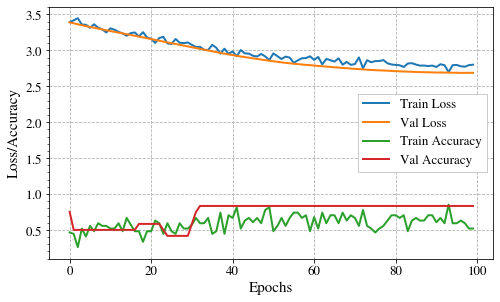

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter,AutoMinorLocator
import matplotlib as mpl
import json
plt.style.use('./fig.mplstyle')

fig, ax = plt.subplots()

# plt.xticks(np.arange(0,EPOCHS, 2))

ax.plot(r.history["loss"], linestyle = '-', lw=2, label="Train Loss", alpha=1)
ax.plot(r.history["val_loss"], linestyle = '-', lw=2, label="Val Loss", alpha=1)
ax.plot(r.history["accuracy"], linestyle = '-', lw=2, label="Train Accuracy", alpha=1)
ax.plot(r.history["val_accuracy"], linestyle = '-', lw=2, label="Val Accuracy", alpha=1)
# ax.plot(np.arange(1,EPOCHS+1), r.history['lr'], linestyle = '-', lw=2, label="Learning rate", alpha=1)

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss/Accuracy')

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_locator(  AutoMinorLocator(5))
ax.yaxis.major.formatter._useMathText = True
ax.legend(frameon=True, loc='best',ncol=1, handlelength=2, framealpha=1, edgecolor="0.8", fancybox=False)
plt.grid(True, ls="--", lw=0.8)

plt.savefig('./1DCNN_training.png', dpi=300, transparent=False, bbox="tight")

plt.show()


In [ ]:
print(model.evaluate(x_test, y_test, batch_size=BATCH_SIZE))

4/4 [==============================] - 0s 7ms/step - loss: 2.7739 - accuracy: 0.8750
[2.773920774459839, 0.875]


In [ ]:
preds = model.predict(x_test)
preds = np.squeeze(np.where(preds >= 0.5, 1, 0), axis=-1)

In [ ]:
target_names = ['turn_on', 'turn_off']
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

     turn_on       0.80      1.00      0.89         4
    turn_off       1.00      0.75      0.86         4

    accuracy                           0.88         8
   macro avg       0.90      0.88      0.87         8
weighted avg       0.90      0.88      0.87         8



In [ ]:
save_model(model, './model_1dconv_e{}-bs{}-a{:.2f}-va{:.2f}.h5'.format(EPOCHS, BATCH_SIZE, 100*r.history['accuracy'][-1], 100*r.history['val_accuracy'][-1]))

In [ ]:
model.save_weights('./model_1dconv_weights_e{}-bs{}-a{:.2f}-va{:.2f}.h5'.format(EPOCHS, BATCH_SIZE, 100*r.history['accuracy'][-1], 100*r.history['val_accuracy'][-1]))

In [ ]:
def plot_confusion_matrix_custom(cm, classes, normalize=False, title='Confusion matrix', cmap='PuBu'):
    import itertools
    plt.figure(figsize=[5, 4])
    plt.grid(False)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig("./1DCNN_cm.png", dpi=300, transparent=True, bbox="tight", pad=0)
    plt.show()

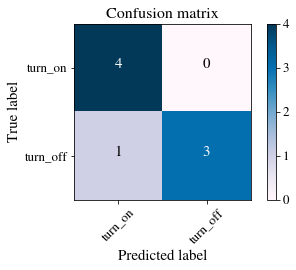

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

confusion_matrix_output = confusion_matrix(y_test, preds)
plot_confusion_matrix_custom(confusion_matrix_output, classes=['turn_on', 'turn_off'], title='Confusion matrix')

In [ ]:
from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle
def plot_custom_roc(y_test, preds):
  plt.figure(figsize=[10,8])
  fpr, tpr, _ = roc_curve(y_test, preds)
  roc_auc = auc(fpr, tpr)
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
  lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.tight_layout()
  plt.savefig("./1DCNN_roc.png", dpi=300, transparent=True, bbox="tight", pad=0)
  plt.show()

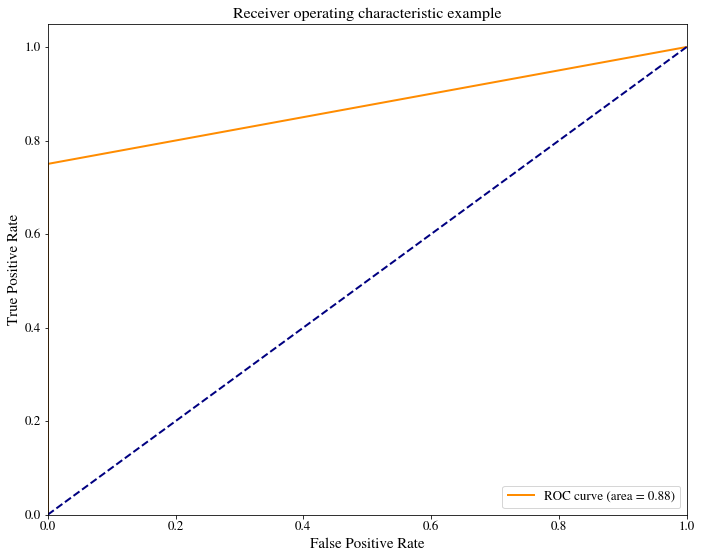

In [ ]:
plot_custom_roc(y_test, preds)